In [6]:
#!pip install pandas

In [7]:
from utils2_pos import get_word_tag, preprocess  
import pandas as pd
from collections import defaultdict
import math
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn_crfsuite import CRF, scorers, metrics
import eli5

<h1><center><font size=7><strong><em>DATASET OVERVİEW</em></strong></font></center></h1>


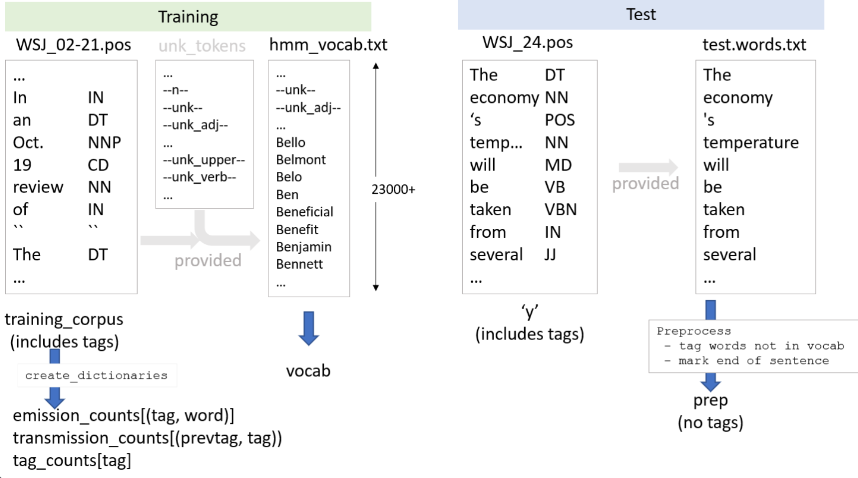

In [8]:
with open("ing/WSJ_02-21.pos", 'r') as f:
    training_corpus = f.readlines()
print(f"A few items of the training corpus list")
print(training_corpus[:5])

A few items of the training corpus list
['In\tIN\n', 'an\tDT\n', 'Oct.\tNNP\n', '19\tCD\n', 'review\tNN\n']


In [9]:
with open("ing/hmm_vocab.txt", 'r') as f:
    voc_l = f.read().split('\n')

print(np.shape(voc_l))
print("First 50 words")
print(f"{voc_l[0:50]}","\n")
print("Last 50 words")
print(f"{voc_l[-50:23777]}", "\n")

(23777,)
First 50 words
['!', '#', '$', '%', '&', "'", "''", "'40s", "'60s", "'70s", "'80s", "'86", "'90s", "'N", "'S", "'d", "'em", "'ll", "'m", "'n'", "'re", "'s", "'til", "'ve", '(', ')', ',', '-', '--', '--n--', '--unk--', '--unk_adj--', '--unk_adv--', '--unk_digit--', '--unk_noun--', '--unk_punct--', '--unk_upper--', '--unk_verb--', '.', '...', '0.01', '0.0108', '0.02', '0.03', '0.05', '0.1', '0.10', '0.12', '0.13', '0.15'] 

Last 50 words
['yards', 'yardstick', 'year', 'year-ago', 'year-before', 'year-earlier', 'year-end', 'year-on-year', 'year-round', 'year-to-date', 'year-to-year', 'yearlong', 'yearly', 'years', 'yeast', 'yelled', 'yelling', 'yellow', 'yen', 'yes', 'yesterday', 'yet', 'yield', 'yielded', 'yielding', 'yields', 'you', 'young', 'younger', 'youngest', 'youngsters', 'your', 'yourself', 'youth', 'youthful', 'yuppie', 'yuppies', 'zero', 'zero-coupon', 'zeroing', 'zeros', 'zinc', 'zip', 'zombie', 'zone', 'zones', 'zoning', '{', '}', ''] 



In [10]:
vocab = {}

for i, word in enumerate(sorted(voc_l)):
    vocab[word] = i

print("Word dictionary, word value is a unique integer key")
cnt = 0

for k,v in vocab.items():
    print(f"{k}: {v}")
    cnt += 1
    if cnt > 20:
        break

Word dictionary, word value is a unique integer key
: 0
!: 1
#: 2
$: 3
%: 4
&: 5
': 6
'': 7
'40s: 8
'60s: 9
'70s: 10
'80s: 11
'86: 12
'90s: 13
'N: 14
'S: 15
'd: 16
'em: 17
'll: 18
'm: 19
'n': 20


In [11]:
with open("ing/WSJ_24.pos", 'r') as f:
    y = f.readlines()

print("Examples of test dataset words")
print(y[:10])

Examples of test dataset words
['The\tDT\n', 'economy\tNN\n', "'s\tPOS\n", 'temperature\tNN\n', 'will\tMD\n', 'be\tVB\n', 'taken\tVBN\n', 'from\tIN\n', 'several\tJJ\n', 'vantage\tNN\n']


In [12]:
_, prep = preprocess(vocab, "ing/test.words")
print('Length of the test dataset undergoing preprocessing: ', len(prep))
print('Test dataset examples: ')
print(prep[:10])

Length of the test dataset undergoing preprocessing:  34199
Test dataset examples: 
['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken', 'from', 'several', '--unk--']


In [13]:
def create_dictionaries(training_corpus, vocab, verbose=True):

    # initialize the dictionaries using defaultdict
    emission_counts = defaultdict(int)
    transition_counts = defaultdict(int)
    tag_counts = defaultdict(int)
    
    # Initialize "prev_tag" (previous tag) with the start state, denoted by '--s--'
    prev_tag = '--s--' 

    # use 'i' to track the line number in the corpus
    i = 0 

    # Each item in the training corpus contains a word and its POS tag
    # Go through each word and its tag in the training corpus
    for word_tag in training_corpus:

        # Increment the word_tag count
        i += 1

        # Every 50,000 words, print the word count
        if i % 50000 == 0 and verbose:
            print(f"number of word = {i}")

        # get the word and tag using the get_word_tag helper function
        word, tag = get_word_tag(word_tag, vocab)

        # Increment the transition count for the previous word and tag
        transition_counts[(prev_tag, tag)] += 1

        # Increment the emission count for the tag and word
        emission_counts[(tag, word)] += 1

        # Increment the tag count
        tag_counts[tag] += 1

        # Set the previous tag to this tag
        prev_tag = tag
        
    return emission_counts, transition_counts, tag_counts

In [14]:
emission_counts, transition_counts, tag_counts = create_dictionaries(training_corpus, vocab)

number of word = 50000
number of word = 100000
number of word = 150000
number of word = 200000
number of word = 250000
number of word = 300000
number of word = 350000
number of word = 400000
number of word = 450000
number of word = 500000
number of word = 550000
number of word = 600000
number of word = 650000
number of word = 700000
number of word = 750000
number of word = 800000
number of word = 850000
number of word = 900000
number of word = 950000


In [15]:
states = sorted(tag_counts.keys())
print(f"Number of POS tags ('states' number of key variable) : {len(states)}")
print("POS Tags")
print(states)

Number of POS tags ('states' number of key variable) : 46
POS Tags
['#', '$', "''", '(', ')', ',', '--s--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


In [16]:
print("transition example: ")
for ex in list(transition_counts.items())[:3]:
    print(ex)
print()

print("emission example: ")
for ex in list(emission_counts.items())[200:203]:
    print (ex)
print()

print("undefined word example: ")
for tup,cnt in emission_counts.items():
    if tup[1] == 'back': print (tup, cnt) 

transition example: 
(('--s--', 'IN'), 5050)
(('IN', 'DT'), 32364)
(('DT', 'NNP'), 9044)

emission example: 
(('DT', 'any'), 721)
(('NN', 'decrease'), 7)
(('NN', 'insider-trading'), 5)

undefined word example: 
('RB', 'back') 304
('VB', 'back') 20
('RP', 'back') 84
('JJ', 'back') 25
('NN', 'back') 29
('VBP', 'back') 4


In [12]:
def predict_pos(prep, y, emission_counts, vocab, states):
  
    # Initialize the number of correct predictions to zero
    num_correct = 0
    
    # Get the (tag, word) tuples, stored as a set
    all_words = set(emission_counts.keys())
    
    # Get the number of (word, POS) tuples in the corpus 'y'
    total = len(y)
    for word, y_tup in zip(prep, y): 

        # Split the (word, POS) string into a list of two items
        y_tup_l = y_tup.split()
        
        # Verify that y_tup contain both word and POS
        if len(y_tup_l) == 2:
            
            # Set the true POS label for this word
            true_label = y_tup_l[1]

        else:
            # If the y_tup didn't contain word and POS, go to next word
            continue
    
        count_final = 0
        pos_final = ''
        
        # If the word is in the vocabulary...
        if word in vocab:
            for pos in states:
                        
                # define the key as the tuple containing the POS and word
                key = (pos, word)

                # check if the (pos, word) key exists in the emission_counts dictionary
                if key in emission_counts: # complete this line

                # get the emission count of the (pos,word) tuple 
                    count = emission_counts[key]

                    # keep track of the POS with the largest count
                    if count > count_final: # complete this line

                        # update the final count (largest count)
                        count_final = count

                        # update the final POS
                        pos_final = pos

            # If the final POS (with the largest count) matches the true POS:
            if pos_final == true_label: # complete this line
                
                # Update the number of correct predictions
                num_correct += 1
            
    accuracy = num_correct / total
    
    return accuracy

In [13]:
accuracy_predict_pos = predict_pos(prep, y, emission_counts, vocab, states)
print(f"Accuracy of prediction using predict_pos is {accuracy_predict_pos:.4f}")

Accuracy of prediction using predict_pos is 0.8889


In [14]:
def create_transition_matrix(alpha, tag_counts, transition_counts):
 
    # Get a sorted list of unique POS tags
    all_tags = sorted(tag_counts.keys())
    
    # Count the number of unique POS tags
    num_tags = len(all_tags)
    
    # Initialize the transition matrix 'A'
    A = np.zeros((num_tags,num_tags))
    
    # Get the unique transition tuples (previous POS, current POS)
    trans_keys = set(transition_counts.keys())
     
    # Go through each row of the transition matrix A
    for i in range(num_tags):
        
        # Go through each column of the transition matrix A
        for j in range(num_tags):

            # Initialize the count of the (prev POS, current POS) to zero
            count = 0
        
            # Define the tuple (prev POS, current POS)
            # Get the tag at position i and tag at position j (from the all_tags list)
            key = (all_tags[i], all_tags[j])

            # Check if the (prev POS, current POS) tuple 
            # exists in the transition counts dictionary
            if transition_counts: #complete this line
                
                # Get count from the transition_counts dictionary 
                # for the (prev POS, current POS) tuple
                count = transition_counts[key]
                
            # Get the count of the previous tag (index position i) from tag_counts
            count_prev_tag = tag_counts[all_tags[i]]
            
            # Apply smoothing using count of the tuple, alpha, 
            # count of previous tag, alpha, and total number of tags
            A[i,j] = (count + alpha) / (count_prev_tag + alpha * num_tags)
    
    return A

In [15]:
alpha = 0.001
A = create_transition_matrix(alpha, tag_counts, transition_counts)

print(f"A at row 0, col 0: {A[0,0]:.9f}")
print(f"A at row 3, col 1: {A[3,1]:.4f}")

print("View a subset of transition matrix A")
A_sub = pd.DataFrame(A[30:35,30:35], index=states[30:35], columns = states[30:35] )
print(A_sub)

A at row 0, col 0: 0.000007040
A at row 3, col 1: 0.1691
View a subset of transition matrix A
              RBS            RP           SYM        TO            UH
RBS  2.217069e-06  2.217069e-06  2.217069e-06  0.008870  2.217069e-06
RP   3.756509e-07  7.516775e-04  3.756509e-07  0.051089  3.756509e-07
SYM  1.722772e-05  1.722772e-05  1.722772e-05  0.000017  1.722772e-05
TO   4.477336e-05  4.472863e-08  4.472863e-08  0.000090  4.477336e-05
UH   1.030439e-05  1.030439e-05  1.030439e-05  0.061837  3.092348e-02


In [16]:
def create_emission_matrix(alpha, tag_counts, emission_counts, vocab):
    
    # get the number of POS tag
    num_tags = len(tag_counts)
    
    # Get a list of all POS tags
    all_tags = sorted(tag_counts.keys())
    
    # Get the total number of unique words in the vocabulary
    num_words = len(vocab)
    
    # Initialize the emission matrix B with places for
    # tags in the rows and words in the columns
    B = np.zeros((num_tags, num_words))
    
    # Get a set of all (POS, word) tuples 
    # from the keys of the emission_counts dictionary
    emis_keys = set(list(emission_counts.keys()))
    
    # Go through each row (POS tags)
    for i in range(num_tags): # complete this line
        
        # Go through each column (words)
        for j in range(num_words): # complete this line

            # Initialize the emission count for the (POS tag, word) to zero
            count = 0
                    
            # Define the (POS tag, word) tuple for this row and column
            key =  (all_tags[i], vocab[j])

            # check if the (POS tag, word) tuple exists as a key in emission counts
            if key in emission_counts.keys(): # complete this line
        
                # Get the count of (POS tag, word) from the emission_counts d
                count = emission_counts[key]
                
            # Get the count of the POS tag
            count_tag = tag_counts[all_tags[i]]
                
            # Apply smoothing and store the smoothed value 
            # into the emission matrix B for this row and column
            B[i,j] = (count + alpha) / (count_tag + alpha * num_words)
            
    return B

In [17]:
# creating your emission probability matrix. this takes a few minutes to run. 
B = create_emission_matrix(alpha, tag_counts, emission_counts, list(vocab))

print(f"View Matrix position at row 0, column 0: {B[0,0]:.9f}")
print(f"View Matrix position at row 3, column 1: {B[3,1]:.9f}")

# Try viewing emissions for a few words in a sample dataframe
cidx  = ['725','adroitly','engineers', 'promoted', 'synergy']

# Get the integer ID for each word
cols = [vocab[a] for a in cidx]

# Choose POS tags to show in a sample dataframe
rvals =['CD','NN','NNS', 'VB','RB','RP']

# For each POS tag, get the row number from the 'states' list
rows = [states.index(a) for a in rvals]

# Get the emissions for the sample of words, and the sample of POS tags
B_sub = pd.DataFrame(B[np.ix_(rows,cols)], index=rvals, columns = cidx )
print(B_sub)

View Matrix position at row 0, column 0: 0.000006032
View Matrix position at row 3, column 1: 0.000000720
              725      adroitly     engineers      promoted       synergy
CD   8.201296e-05  2.732854e-08  2.732854e-08  2.732854e-08  2.732854e-08
NN   7.521128e-09  7.521128e-09  7.521128e-09  7.521128e-09  2.257091e-05
NNS  1.670013e-08  1.670013e-08  4.676203e-04  1.670013e-08  1.670013e-08
VB   3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08  3.779036e-08
RB   3.226454e-08  6.456135e-05  3.226454e-08  3.226454e-08  3.226454e-08
RP   3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07  3.723317e-07


In [18]:
def initialize(states, tag_counts, A, B, corpus, vocab):

    # Get the total number of unique POS tags
    num_tags = len(tag_counts)
    
    # Initialize best_probs matrix 
    # POS tags in the rows, number of words in the corpus as the columns
    best_probs = np.zeros((num_tags, len(corpus)))
    
    # Initialize best_paths matrix
    # POS tags in the rows, number of words in the corpus as columns
    best_paths = np.zeros((num_tags, len(corpus)), dtype=int)
    
    # Define the start token
    s_idx = states.index("--s--")
    
    # Go through each of the POS tags
    for i in range(num_tags): 
        
        # Handle the special case when the transition from start token to POS tag i is zero
        if A[s_idx,i] == 0: 
            
            # Initialize best_probs at POS tag 'i', column 0, to negative infinity
            best_probs[i,0] = float('-inf')
        
        else:
            
            # Initialize best_probs at POS tag 'i', column 0
            best_probs[i,0] = math.log(A[s_idx,i]) + math.log(B[i, vocab[corpus[0]]])
                        
    return best_probs, best_paths

In [19]:
best_probs, best_paths = initialize(states, tag_counts, A, B, prep, vocab)

In [20]:
print(f"best_probs[0,0]: {best_probs[0,0]:.4f}") 
print(f"best_paths[2,3]: {best_paths[2,3]:.4f}")

best_probs[0,0]: -22.6098
best_paths[2,3]: 0.0000


In [21]:
def viterbi_forward(A, B, test_corpus, best_probs, best_paths, vocab):

    # Get the number of unique POS tags (which is the num of rows in best_probs)
    num_tags = best_probs.shape[0]
    
    # Go through every word in the corpus starting from word 1
    # Recall that word 0 was initialized in `initialize()`
    for i in range(1, len(test_corpus)): 
        
        # Print number of words processed, every 5000 words
        if i % 5000 == 0:
            print("Words processed: {:>8}".format(i))
            
        # For each unique POS tag that the current word can be
        for j in range(num_tags): # complete this line
            
            # Initialize best_prob for word i to negative infinity
            best_prob_i = float("-inf")
            
            # Initialize best_path for current word i to None
            best_path_i = None

            # For each POS tag that the previous word can be:
            for k in range(num_tags): # complete this line
            
                # Calculate the probability = 
                # best probs of POS tag k, previous word i-1 + 
                # log(prob of transition from POS k to POS j) + 
                # log(prob that emission of POS j is word i)
                prob = best_probs[k, i - 1] + math.log(A[k, j]) + math.log(B[j, vocab[test_corpus[i]]])

                # check if this path's probability is greater than
                # the best probability up to and before this point
                if prob > best_prob_i: # complete this line
                    
                    # Keep track of the best probability
                    best_prob_i = prob
                    
                    # keep track of the POS tag of the previous word
                    # that is part of the best path.  
                    # Save the index (integer) associated with 
                    # that previous word's POS tag
                    best_path_i = k

            # Save the best probability for the 
            # given current word's POS tag
            # and the position of the current word inside the corpus
            best_probs[j,i] = best_prob_i
            
            # Save the unique integer ID of the previous POS tag
            # into best_paths matrix, for the POS tag of the current word
            # and the position of the current word inside the corpus.
            best_paths[j,i] = best_path_i

    return best_probs, best_paths

In [22]:
best_probs, best_paths = viterbi_forward(A, B, prep, best_probs, best_paths, vocab)

Words processed:     5000
Words processed:    10000
Words processed:    15000
Words processed:    20000
Words processed:    25000
Words processed:    30000


In [23]:
print(f"best_probs[0,1]: {best_probs[0,1]:.4f}") 
print(f"best_probs[0,4]: {best_probs[0,4]:.4f}") 

best_probs[0,1]: -24.7822
best_probs[0,4]: -49.5601


In [24]:
def viterbi_backward(best_probs, best_paths, corpus, states):

    # Get the number of words in the corpus
    # which is also the number of columns in best_probs, best_paths
    m = best_paths.shape[1] 
    
    # Initialize array z, same length as the corpus
    z = [None] * m
    
    # Get the number of unique POS tags
    num_tags = best_probs.shape[0]
    
    # Initialize the best probability for the last word
    best_prob_for_last_word = float('-inf')
    
    # Initialize pred array, same length as corpus
    pred = [None] * m
    
    # Go through each POS tag for the last word (last column of best_probs)
    # in order to find the row (POS tag integer ID) 
    # with highest probability for the last word
    for k in range(num_tags): # complete this line

        # If the probability of POS tag at row k 
        # is better than the previosly best probability for the last word:
        if best_probs[k, m - 1] > best_prob_for_last_word: # complete this line
            
            # Store the new best probability for the last word
            best_prob_for_last_word = best_probs[k, m - 1]
    
            # Store the unique integer ID of the POS tag
            # which is also the row number in best_probs
            z[m - 1] = k
            
    # Convert the last word's predicted POS tag
    # from its unique integer ID into the string representation
    # using the 'states' list
    # store this in the 'pred' array for the last word
    pred[m - 1] = states[k]
    
    # Find the best POS tags by walking backward through the best_paths
    # From the last word in the corpus to the 0th word in the corpus
    for i in range(len(corpus) - 1, -1, -1): # complete this line
        
        # Retrieve the unique integer ID of
        # the POS tag for the word at position 'i' in the corpus
        pos_tag_for_word_i = z[i]
        
        # In best_paths, go to the row representing the POS tag of word i
        # and the column representing the word's position in the corpus
        # to retrieve the predicted POS for the word at position i-1 in the corpus
        z[i - 1] = best_paths[pos_tag_for_word_i, i]
        
        # Get the previous word's POS tag in string form
        # Use the 'states' list, 
        # where the key is the unique integer ID of the POS tag,
        # and the value is the string representation of that POS tag
        pred[i - 1] = states[z[i - 1]]
        
    return pred

In [25]:
pred = viterbi_backward(best_probs, best_paths, prep, states)
m=len(pred)
print('The prediction for pred[-7:m-1] is: \n', prep[-7:m-1], "\n", pred[-7:m-1], "\n")
print('The prediction for pred[0:8] is: \n', pred[0:7], "\n", prep[0:7])

The prediction for pred[-7:m-1] is: 
 ['see', 'them', 'here', 'with', 'us', '.'] 
 ['VB', 'PRP', 'RB', 'IN', 'PRP', '.'] 

The prediction for pred[0:8] is: 
 ['DT', 'NN', 'POS', 'NN', 'MD', 'VB', 'VBN'] 
 ['The', 'economy', "'s", 'temperature', 'will', 'be', 'taken']


In [26]:
print('The third word is:', prep[3])
print('Your prediction is:', pred[3])
print('Your corresponding label y is: ', y[3])

The third word is: temperature
Your prediction is: NN
Your corresponding label y is:  temperature	NN



In [27]:
def compute_accuracy(pred, y):

    num_correct = 0
    total = 0
    
    # Zip together the prediction and the labels
    for prediction, y in zip(pred, y):
        word_tag_tuple = y.split()
        
        if len(word_tag_tuple)!=2: 
            continue

        # store the word and tag separately
        word, tag = word_tag_tuple

        # POS tag label matches the prediction
        if prediction == tag: 
            
            # count the number of times that the prediction
            num_correct += 1
            
        # keep track of the total number of examples
        total += 1
        
    return num_correct / total

In [28]:
print(f"Accuracy of the Viterbi algorithm is {compute_accuracy(pred, y):.4f}")

Accuracy of the Viterbi algorithm is 0.9531
